In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## New data augmentation techniques: mixup, ricap, cutmix...

As you may know, Jeremy claims in his course that data augmentation is perhaps the most important regularization technique when training a model for Computer Vision, second only to getting more data samples (which is often costly or just impossible).

There are a large number of “classical” transforms, most of them already available in fastai (flip, rotate, zoom, cutout, etc). All these transformations have something in common: they are single-image transforms. This means we just use one image to generate a new image. They are used to increase our dataset size by generating new, realistic images.

However, during the last couple of years, new image transformations that blend 2 or more images to create a new image have been released. In this notebook we'll briefly review some of these methods. 

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.vision import *
from fastai.metrics import error_rate

I've created some code we need to import to be able to use these new data augmentations with the fastai library. Hopefully, one day they will be part of the fastai library and won't need to do this.

In [7]:
from exp.nb_new_data_augmentation import *

In [8]:
size=128
bs = 32
path = untar_data(URLs.IMAGENETTE_160); path

PosixPath('/home/oguiza/.fastai/data/imagenette-160')

In this case I'm creating a databunch without any transforms (other than size) so that it's easier to visualize the real impact of each transformation.
This is for demo purposes only. When you use the new data augmentations, you'll be able to decide whether you want to use them jointly with single-image transforms, or just on their own.

In [9]:
data = (ImageList.from_folder(path)
        .use_partial_data(0.01)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size)
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

learn = Learner(data, models.resnet34())

## Single-image transforms

These are some of the transforms we are all familiar with. All of them are applied to each individual image. I've selected many of them (some may not make sense) for demo purposes. 

With single-image transforms, we try to increase the amount of available images, and usually select the ones that look more natural to us (those that could be real images). We would usually avoid some flips or excessive rotation. 

With .show_single_img_tfms() you can actually visualize the impact of the selected transforms on a single image so that you can decide if the selected tfms work as you expect.

In [4]:
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .use_partial_data(0.01)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms, size=size)
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))
tfms

NameError: name 'get_transforms' is not defined

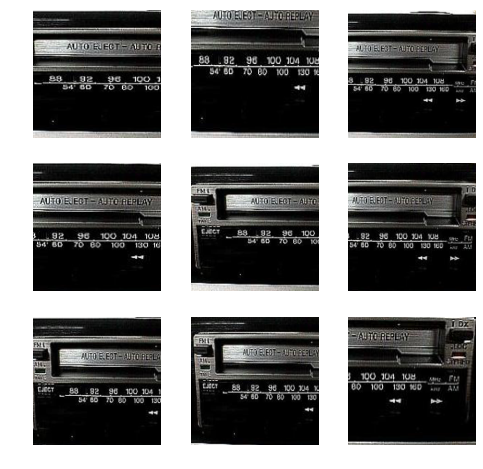

In [6]:
learn = Learner(data, models.resnet34()).show_single_img_tfms()

### Cutout (DeVries, 2017)

This is a single-image transformation, but it's very close to some of the newer multi-image ones, since it randomly selects an area that is removed. 

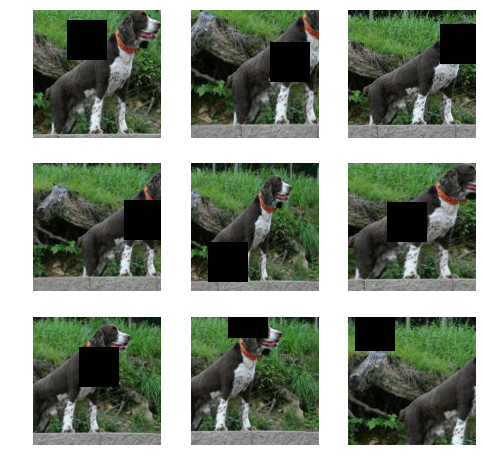

In [120]:
learn.data.train_ds.tfms = [cutout()]
learn.show_single_img_tfms();

### GridZero

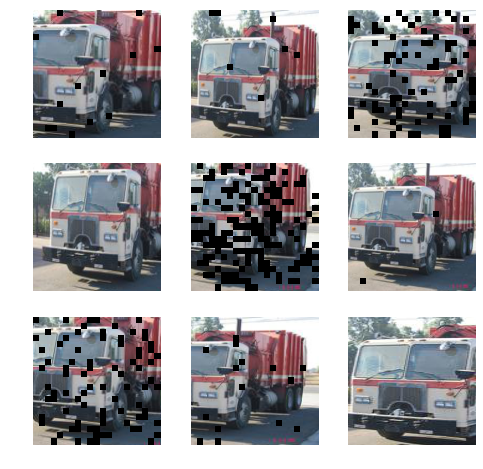

In [26]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [gridzero(size=.05, alpha=.2)]
learn.show_single_img_tfms();

### GridCut

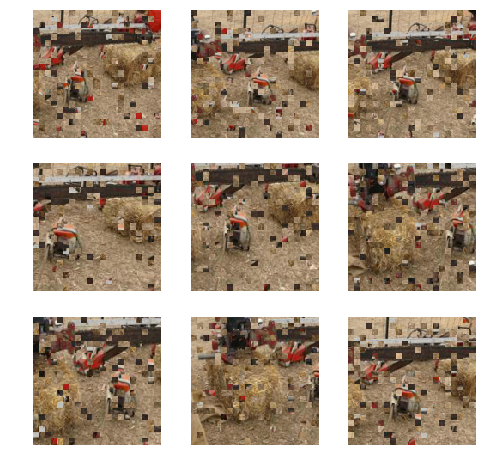

In [10]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [gridcut(size=0.05, alpha=1., proba=True)]
learn.show_single_img_tfms();

### GridMix

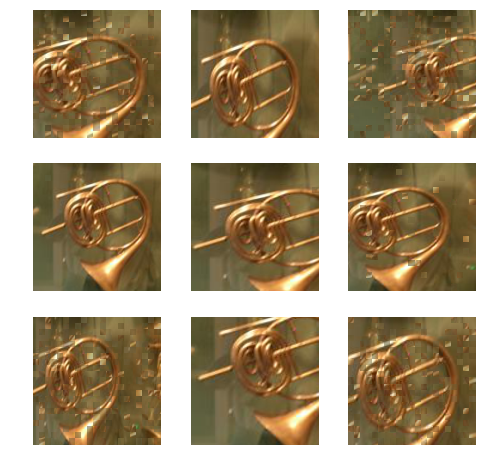

In [11]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [gridmix(size=0.05, alpha=.2, proba=False)]
learn.show_single_img_tfms();

### RandomZero

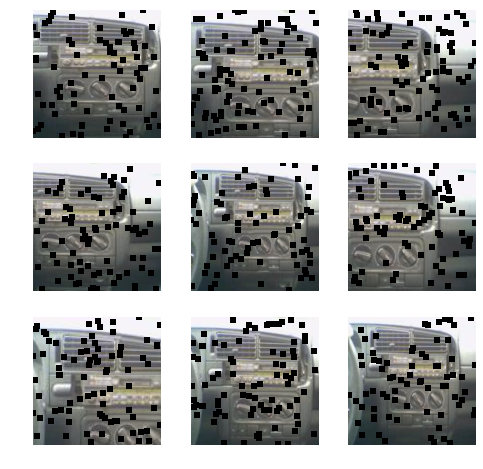

In [13]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [randzero(size=0.05, alpha=.2, proba=True)]
learn.show_single_img_tfms();

### RandomCut

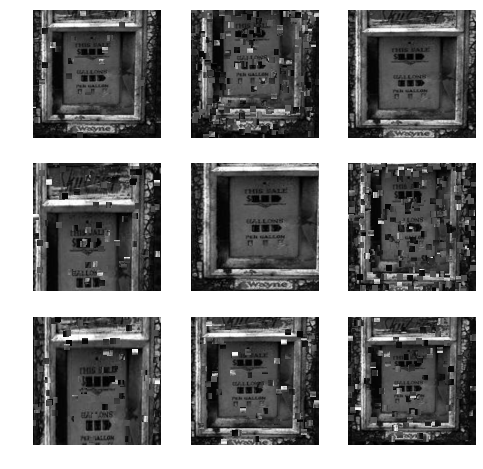

In [15]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [randcut(size=0.05, alpha=.2, proba=False)]
learn.show_single_img_tfms();

### RandomMix

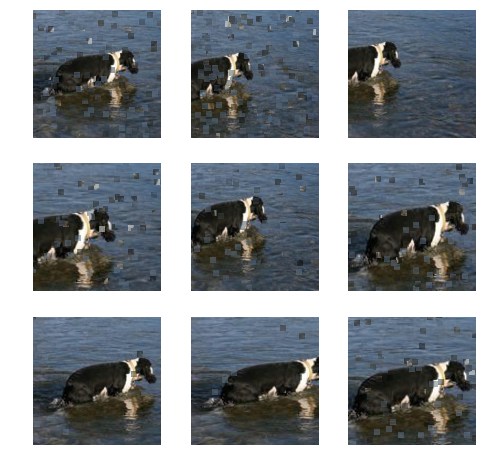

In [16]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [randmix(size=0.05, alpha=.2, proba=False)]
learn.show_single_img_tfms();

### Blender

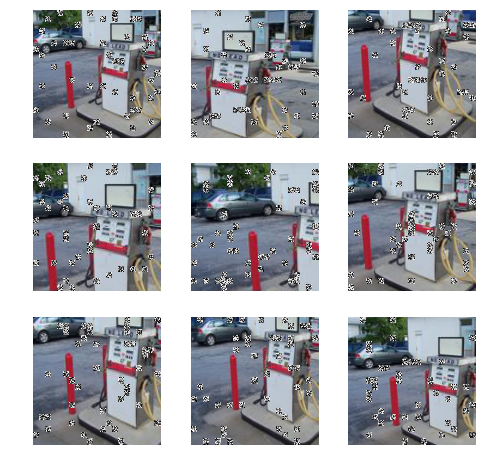

In [7]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [blend(size=0.05, alpha=.1, blend='noise', grid=True, same=True, proba=True)]
learn.show_single_img_tfms();

## Multi-image transforms

There are at least a couple of things multi-image data transforms have in common: 

- they combine 2 or more images to create a new synthetic image
- unlike previous techniques like cutout, the entire image provides informative pixels. 

In this case I'm creating a databunch without any transforms (other than size) so that it's easier to visualize the real impact of each transformation.

This is for demo purposes only. When you use the new data augmentations, you'll be able to decide whether you want to use them jointly with single-image transforms, or just on their own.

In [8]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size) # <-- no transforms 
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

I've created a new function (show_multi_img_tfms) that you can use to easily visualize images created by a callback.

As you'll see, new data augmentation images are sometimes not realistic to us, but they are helpful to improve performance in vision tasks.

### Mixup (Zhang, 2018)

https://arxiv.org/abs/1710.09412

Mixup blends two images drawn at random from our training data. A weight λ (between .5-1) is assigned to the first sample, and 1-λ to the second one. 
Despite its simplicity, mixup allows a new state-of-the-art performance in the CIFAR-10, CIFAR- 100, and ImageNet-2012 image classification datasets.

In [ ]:
learn = Learner(data, models.resnet34()).mixup()
learn.show_multi_img_tfms();

Isn't it weird that this increases performance??

### Ricap (Takahashi, 2018)

RICAP (Random Image Cropping and Patching) crops four training images and patches them to construct a new training image; it selects images and determines the cropping sizes randomly, where the size of the final image is identical to that of the original image.

RICAP achieves a new state-of-the-art test error of 2.19% on CIFAR-10. We also confirmed that deep CNNs with RICAP achieve better results on classification tasks using CIFAR-100 and ImageNet and an image-caption retrieval task using Microsoft COCO.

It's applied in the following way:
- a pixel coordinate in the image is randomly selected. That creates 4 areas within an image.
- 4 regions from different images are cropped and patched to create a new image. 

In [ ]:
learn = Learner(data, models.resnet34()).ricap(beta=.1).show_multi_img_tfms()

In [ ]:
learn = Learner(data, models.resnet34()).ricap(beta=1.).show_multi_img_tfms()

### Cutmix (Yun, 2019)

https://arxiv.org/abs/1905.04899

Cutmix is similar to Cutout, as a single patch is cut and pasted into a different training image.

CutMix consistently outperforms the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly- supervised localization task.


In [ ]:
learn = Learner(data, models.resnet34()).cutmix(alpha=.1).show_multi_img_tfms()

In [ ]:
learn = Learner(data, models.resnet34()).cutmix(alpha=1.).show_multi_img_tfms()

## How to train using data augmentation?

It's super easy! The only thing you need to do is: 

1. First you will create your ImageDataBunch as you would normally do.
You'll need to decide if you want to apply single-image transformations when you create the databunch. If you decide to use it, just add:

In [ ]:
# single-image transforms
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms=tfms, size=size) # <-- single-img transforms
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

2. The you will create the learner as usual, but you will add to it the selected multi-image transform you have selected (mixup, ricap or cutmix). You can only select one of these new data augmentations at a time.

In [ ]:
# multi-image transforms
learn = Learner(data, models.resnet34()).cutmix()

That's it!!. 
We can now visualize our images just to check everything's working well.

In [ ]:
learn.show_multi_img_tfms();

You can also do both in a single step

In [ ]:
learn = Learner(data, models.resnet34(), metrics=error_rate).cutmix().show_multi_img_tfms()

## Scheduled tfm

### Single parameter

functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False) 

functools.partial(<class 'exp.nb_new_data_augmentation.TfmScheduler'>, tfm_fn=functools.partial(TfmPixel (gridcut), size=0.05, proba=True), sch_param='alpha', sch_val=0.25, sch_iter=None, sch_func=functools.partial(<function annealing_cos at 0x7f5435ce9f28>), plot=True, test=False) 

self.end_iter: 120

 alpha between 0.0 and 0.25 in iters 0.00 to 1.00


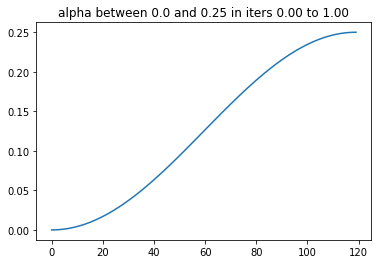

In [94]:
from exp.nb_new_data_augmentation import *
learn = Learner(data, models.resnet34(), metrics=accuracy)

tfm_fn = partial(gridcut, size=.05, proba=True)
sch_param='alpha'
sch_val = .25
sch_iter = None
sch_func = partial(annealing_cos) # annealing_cos, None = annealing_linear, cosine_annealing
plot = True
test = False
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)
for cb in learn.callback_fns: print(cb, '\n')
learn.fit_one_cycle(30)

In [96]:
learn = Learner(data, models.resnet34(), metrics=accuracy, loss_func = LabelSmoothingCrossEntropy())
learn.fit_one_cycle(30)

In [10]:
xb, yb = learn.data.one_batch()

In [12]:
from exp.nb_xresnet_sa import *
xresnet34(sa=True)(xb)

torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 1024])
torch.Size([32, 64, 1024])
torch.Size([32, 64, 64])
torch.Size([32, 64, 1024])
torch.Size([32, 64, 1024])
torch.Size([32, 64, 32, 32])


tensor([[-0.9011,  0.2522,  0.5215,  ..., -0.1548, -0.4371, -0.4193],
        [-0.8604,  0.9036,  0.9112,  ..., -0.5964, -1.1075, -0.6881],
        [-1.0532,  0.2828, -0.3022,  ..., -0.0619, -0.1668, -0.0639],
        ...,
        [-0.2438, -0.1385, -0.1532,  ...,  0.1689,  0.1485, -0.6163],
        [-1.4475,  0.8396,  0.7485,  ..., -0.8547, -0.4291, -0.1830],
        [-0.8137, -0.1699,  0.0344,  ...,  0.0658,  0.3307, -0.0019]],
       grad_fn=<AddmmBackward>)

### Multiple parameters

functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False) 

functools.partial(<class 'exp.nb_new_data_augmentation.TfmScheduler'>, tfm_fn=functools.partial(TfmPixel (gridmix), size=0.05, proba=True), sch_param=['alpha', 'size'], sch_val=[(0.5, 0), (0.2, 0.4)], sch_iter=[0.5, 0.7], sch_func=<function annealing_cos at 0x7fec8455f1e0>, plot=True, test=False) 


 alpha between 0.0 and 0.5 in iters 0.00 to 0.50


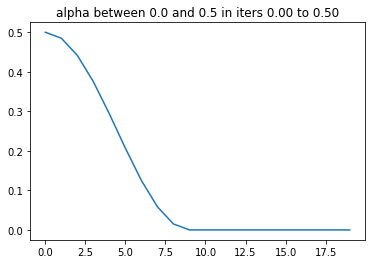


 size between 0.2 and 0.4 in iters 0.00 to 0.70


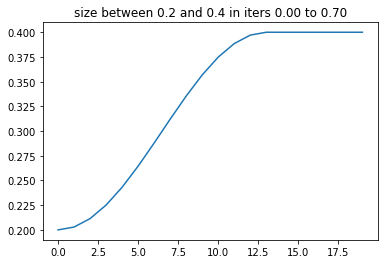

In [21]:
from exp.nb_new_data_augmentation import *
from fastai.callbacks.misc import StopAfterNBatches

tfm_fn = partial(gridmix, size=.05, proba=True)
sch_param=['alpha', 'size']
sch_val = [(.5, 0), (.2, .4)]
sch_iter = [.5, .7]
sch_func = annealing_cos # annealing_cos, None = annealing_linear
plot = True
test = False
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)


learn = Learner(data, models.resnet34(), metrics=accuracy)
learn.callback_fns.append(sch_tfm_cb)
learn.callbacks.append(StopAfterNBatches(n_batches=2))
for cb in learn.callback_fns: print(cb, '\n')
learn.fit_one_cycle(5)

## Sandbox

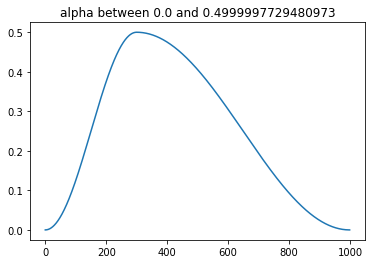

In [86]:
sch_param = 'alpha'
total_iters = 1000
sch_val = (0, .5)
sch_iter = None
#sch_iters = (2, 15)
#sch_iters = None

s = MyScheduler(total_iters, sch_val, sch_iter=sch_iter, sch_func=partial(cosine_annealing))
a = s.start_val
a_ = []
for i in range(total_iters): 
    a = s.step()
    a_.append(a)
plt.plot(a_)
plt.title(f'{sch_param} between {min(a_)} and {max(a_)}')
plt.show()
del s

In [85]:
def cosine_annealing(start:Number, end:Number, pct:float, pct_start=.3, **kwargs)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    if pct <= pct_start: 
        return annealing_cos(start, end, pct/pct_start)
    else: 
        return annealing_cos(end, start, (pct - pct_start)/(1 - pct_start))

In [235]:
def annealing_poly(start:Number, end:Number, pct:float, degree:Number, **kwargs)->Number:
    "Helper function for `anneal_poly`."
    return end + (start-end) * (1-pct)**degree

In [15]:
def inv_annealing_poly(start:Number, end:Number, pct:float, degree:Number, **kwargs)->Number:
    "Helper function for `anneal_poly`."
    return start + (end - start) * (pct)**degree

In [37]:
def inv_annealing_cos(start:Number, end:Number, pct:float, **kwargs)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    pct = max(0, min(1, pct))
    cos_out = np.cos(np.pi * pct) + 1
    return start + (end - start)/2 * cos_out

In [32]:
def annealing_cos(start:Number, end:Number, pct:float, **kwargs)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out

In [200]:
def my_annealing_exp(start:Number, end:Number, pct:float, eps:float=1e-6, **kwargs)->Number:
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    pct = max(0, min(1, pct))
    return (start + eps) * (end/(start + eps)) ** pct

In [201]:
def my_annealing_linear(start:Number, end:Number, pct:float, **kwargs)->Number:
    "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    pct = max(0, min(1, pct))
    return start + pct * (end-start)

In [ ]:
class MyScheduler():
    def __init__(self, vals:StartOptEnd, n_iter:int, func:Optional[AnnealFunc]=None):
        self.start,self.end = (vals[0],vals[1]) if is_tuple(vals) else (vals,0)
        self.n_iter = max(1, n_iter)
        if func is None: self.func = annealing_linear if is_tuple(vals) else annealing_no
        else:          self.func = func
        self.n = 0
        
        
    def restart(self): self.n = 0

    def step(self)->Number:
        "Return next value along annealed schedule."
        out = self.func(self.start, self.end, max(0, min(1, self.n/(self.n_iter - 1))))
        self.n += 1
        return out

In [241]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [gridcut(size=0.05, alpha=.2, proba=False)]
learn.data.train_ds.tfms

[RandTransform(tfm=TfmPixel (gridcut), kwargs={'size': 0.05, 'alpha': 0.2, 'proba': False}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [17]:
def _blender(x, size=.1, alpha=.2, blend='cut', grid=True, same=True, proba=False):
    ''' Blends parts of an image with 
        size: 
            int tuple(pixels, pixels), float tuple (percent img)
            int (pixels) or float (percent_tuple)
        alpha: determines a random probability distribution that each individual patch is modified
        blend: type of blend 'zero', 'cut', 'mix'
        grid: if True patches will be part of a grid, so they won't overlap
        same (used with grid): if True cells will have approx the same size, otherwise random'''

    print('blender:', x.shape, alpha)
    if alpha == 0: return x
    x_size = x.shape
    new_x = x.clone()
    if not isinstance(size, tuple): size = (size, size)
    if isinstance(size[0], float): w = int(size[0] * x_size[-1])
    else: w = size[-1]
    if isinstance(size[1], float): h = int(size[1] * x_size[-2])
    else: h = size[-2]
    n_patches = (x_size[-1] // w, x_size[-2] // h)
    patch_len = n_patches[0] * n_patches[1]
    lambd = np.random.beta(alpha, alpha)
    lambd = max(lambd, 1- lambd)
    if proba:
        patch_ids = np.arange(patch_len)[np.random.rand(patch_len) <= alpha]
    else:
        patch_ids = np.random.choice(np.arange(patch_len), 
                                     int(patch_len * (1 - lambd)), 
                                     replace=False)
    #Grid
    if grid: patches = get_x1_coords(x_size, n_patches, same=same)
    for i in patch_ids:
        #x1 coordinates
        if grid: bby1, bby2, bbx1, bbx2 = patches[i]
        else: bby1, bby2, bbx1, bbx2 = get_x1_rand_coords(x_size, n_patches, w, h)
        # Blend
        if blend.lower() == 'zero': new_x[..., bby1:bby2, bbx1:bbx2] = 0
        else: 
            #x2 coordinates
            ccy1, ccy2, ccx1, ccx2 = get_x2_coords(x_size, bby1, bby2, bbx1, bbx2)
            x2 = x[..., ccy1:ccy2, ccx1:ccx2]
            if blend.lower() == 'mix':
                x1 = x[..., bby1:bby2, bbx1:bbx2]
                new_x[..., bby1:bby2, bbx1:bbx2] = x1 * .5 + x2 * .5
            if blend.lower() == 'cut':
                new_x[..., bby1:bby2, bbx1:bbx2] = x2
    return new_x

blender = TfmPixel(_blender)

xb, yb = learn.data.one_batch()

In [5]:
bs = 32
data = (ImageList.from_folder(path)
        .use_partial_data(0.010)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size)
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (126 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n01440764,n03445777,n03028079,n02102040,n03445777
Path: /home/oguiza/.fastai/data/imagenette-160;

Valid: LabelList (7 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02979186,n03028079,n03425413,n01440764,n01440764
Path: /home/oguiza/.fastai/data/imagenette-160;

Test: None

In [24]:
import math

class TfmScheduler(LearnerCallback):
    
    def __init__(self,
                 learn: Learner,
                 tfm_fn: Callable,
                 sch_param: str,
                 sch_vals: StartOptEnd,
                 sch_iters: Optional[StartOptEnd] = None,
                 func: Optional[AnnealFunc] = None,
                 **kwargs: Any):

        super().__init__(learn)
        self.batches = math.ceil(len(data.train_ds)/data.train_dl.batch_size)
        self.tfm_fn = tfm_fn
        self.sch_param = sch_param
        self.start_val, self.end_val = (
            sch_vals[0], sch_vals[1]) if is_tuple(sch_vals) else (sch_vals, 0)
        self.sch_iters = sch_iters
        if func is None: self.func = annealing_linear if is_tuple(vals) else annealing_no
        else: self.func = func

    def on_train_begin(self, n_epochs: int, epoch: int, **kwargs: Any):
        total_iters = n_epochs * self.batches
        print('n_epochs, epoch, batches, total_iters', n_epochs, epoch, self.batches, total_iters)
        if self.sch_iters is None: start_iter, end_iter = (0, total_iters)
        else:
            start_iter, end_iter = (self.sch_iters[0],self.sch_iters[1]) if is_tuple(
                                        self.sch_iters) else (0, self.sch_iters)
            if isinstance(start_iter, float): start_iter = int(start_iter * total_iters)
            if isinstance(end_iter, float): end_iter = int(end_iter * total_iters)
        eff_iters = end_iter - start_iter
        self.scheduler = MyScheduler(total_iters, sch_vals, sch_iters=sch_iters, func=func)
        self.scheduler.n = 0

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        param = self.scheduler.step()
        if isinstance(self.tfm_fn, functools.partial): 
            fn = self.tfm_fn.func.func
            self.tfm_fn.keywords[self.sch_param] = param
            kw = self.tfm_fn.keywords
        else: 
            kw = {self.sch_param: param}
            fn = self.tfm_fn.func
        new_input = fn(last_input, **kw)
        display(Image(new_input[0]))
        return {'last_input': new_input, 'last_target': last_target}

n_epochs, epoch, batches, total_iters 5 0 4 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.0


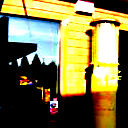

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.0


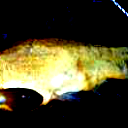

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.0


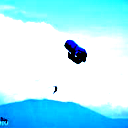

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([7, 3, 128, 128]) 0.0


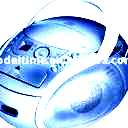

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.0


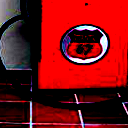

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.02025351319275126
0.0


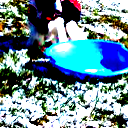

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.0793732335844094
0.0


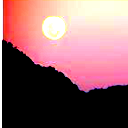

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([7, 3, 128, 128]) 0.1725696330273574
0.49


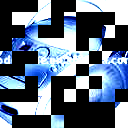

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.2922924934990567
0.0


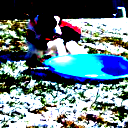

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.42884258086335736
0.33


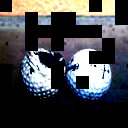

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.5711574191366425
0.46


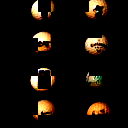

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([7, 3, 128, 128]) 0.7077075065009432
0.09


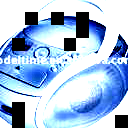

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.8274303669726425
0.0


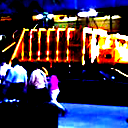

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.9206267664155907
0.45


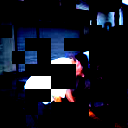

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 0.9797464868072486
0.45


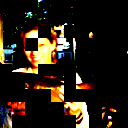

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([7, 3, 128, 128]) 1.0
0.21


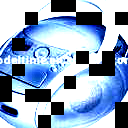

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 1.0
0.37


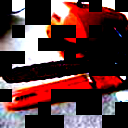

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 1.0
0.44


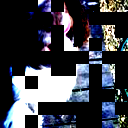

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([32, 3, 128, 128]) 1.0
0.42


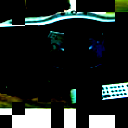

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


blender: torch.Size([7, 3, 128, 128]) 1.0
0.09


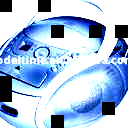

In [25]:
from exp.nb_new_data_augmentation import *
tfm_fn = partial(gridzero)
sch_param='alpha'
sch_vals = (0., 1)
sch_iters = (.2, .8)
func = annealing_cos
learn = Learner(data, models.resnet34())
learn.callback_fns.append(partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, 
                                  sch_vals=sch_vals, sch_iters=None, func=func))
learn.fit_one_cycle(5)

In [360]:
fn = tfm_fn.func
fn(alpha=)

TfmPixel (blender)

In [356]:
if isinstance(tfm_fn, functools.partial): fn = tfm_fn.func.func
else: fn = tfm_fn.func
inspect.getfullargspec(fn)

FullArgSpec(args=['x', 'size', 'alpha', 'blend', 'grid', 'same', 'proba'], varargs=None, varkw=None, defaults=(0.1, 0.2, 'cut', True, True, False), kwonlyargs=[], kwonlydefaults=None, annotations={'return': <class 'fastai.vision.image.Image'>})

In [358]:
fn

<function __main__._blender(x, size=0.1, alpha=0.2, blend='cut', grid=True, same=True, proba=False) -> fastai.vision.image.Image>

In [349]:
inspect.getfullargspec(blender.func)

FullArgSpec(args=['x', 'size', 'alpha', 'blend', 'grid', 'same', 'proba'], varargs=None, varkw=None, defaults=(0.1, 0.2, 'cut', True, True, False), kwonlyargs=[], kwonlydefaults=None, annotations={'return': <class 'fastai.vision.image.Image'>})

In [7]:
xb, yb = learn.data.one_batch()

0.0022675736961451248


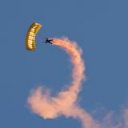

In [219]:
from exp.nb_new_data_augmentation import *
out = _blender(xb[0], size=.05, alpha=.2, blend='mix', grid=False, same=True)
Image(out)

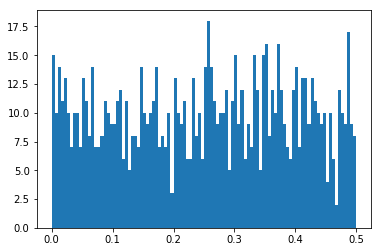

0.25027275647849895


In [26]:
alpha = 1
lambd_ = []
for i in range(1000):
    lambd = np.random.beta(alpha, alpha)
    lambd = max(lambd, 1- lambd)
    lambd_.append(1-lambd)
plt.hist(lambd_, 100)
plt.show()
print(np.mean(lambd_))

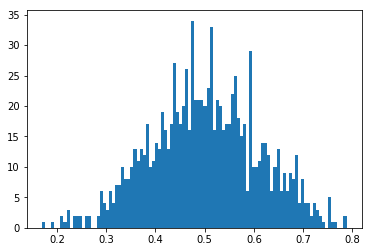

In [22]:
alpha = 10
lambd_ = []
for i in range(1000):
    lambd = np.random.beta(alpha, alpha)
    #lambd = max(lambd, 1- lambd)
    lambd_.append(lambd)
plt.hist(lambd_, 100)
plt.show()

In [49]:
alpha = .2
patch_len = 400

lambd = np.random.beta(alpha, alpha)
lambd = max(lambd, 1- lambd)
patch_ids = np.random.choice(np.arange(patch_len), int(patch_len * (1 - lambd)), replace=False)
len(patch_ids)

0

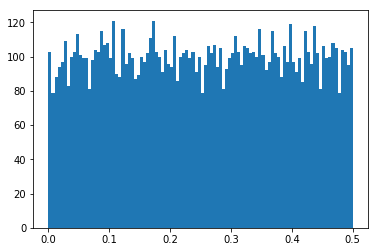

0.2509038910144926 0.1439042044058539 -0.0022394046560823074 -1.2048009589453477


In [70]:
n = 10000
start = 0
width = .5
x = sp.stats.uniform.rvs(size=n, loc = start, scale=width)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

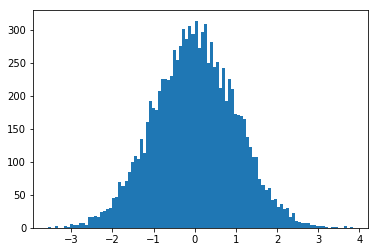

0.00170891436929046 0.9980929815835732 -0.002956758075982742 -0.06501825470866018


In [72]:
x = sp.stats.norm.rvs(size=10000,loc=0,scale=1)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

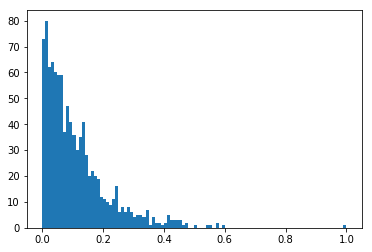

0.11128962118872995 0.10654236176018499 2.0099683460174145 6.914949564813618


In [74]:
x = sp.stats.expon.rvs(scale=1,loc=0,size=1000)
x = x / x.max()
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

In [ ]:
data_expon = expon.rvs(scale=1,loc=0,size=1000)

#### Uniform

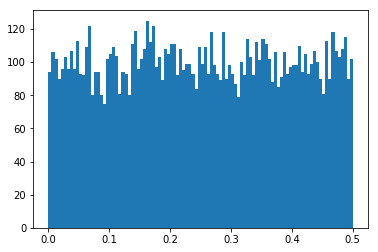

0.25062529665783234 0.14422832493845625 [0.004316] [-1.191889]


In [9]:
import scipy as sp
alpha = 1
x = np.random.beta(alpha, alpha, size=(10000, 1)) * .5
#x = np.concatenate((x, 1 - x), axis=1).min(1)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

#### Gaussian

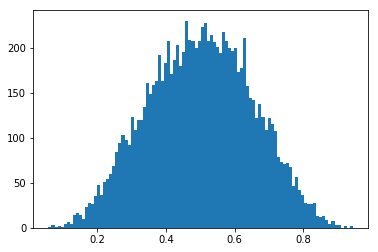

0.5012280285011088 0.15094087800743716 [-0.02363] [-0.509332]


In [17]:
import scipy as sp
alpha = 5
x = np.random.beta(alpha, alpha, size=(10000, 1))
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

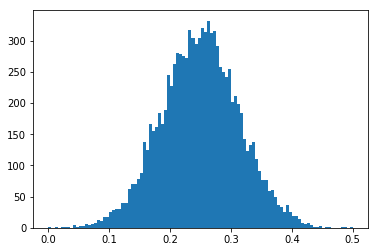

0.249240970695531 0.06383064582623325 -0.0008804581812996849 0.06121957031244074


In [11]:
import scipy as sp
x = np.random.normal(size=10000)
x = (x - x.min()) / (x.max() - x.min()) * .5
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

#### Lambda

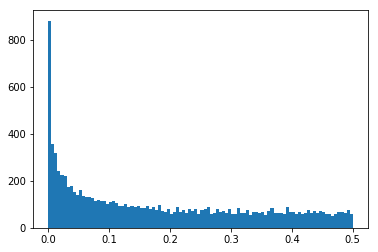

0.18126134620986906 0.15429233122057306 0.5024088723865937 -1.0781744916791425


In [14]:
import scipy as sp
alpha = .5
x = np.random.beta(alpha, alpha, size=(10000, 1))
x = np.concatenate((x, 1 - x), axis=1).min(1)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))